In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import json
from privacypacking.utils.utils import load_logs, global_metrics
import pandas as pd
from experiments.ray.analysis import load_ray_experiment, load_latest_ray_experiment, load_latest_scheduling_results, load_latest_scheduling_results, load_latest_ray_experiment
import plotly.express as px
from privacypacking.budget.curves import  LaplaceCurve, GaussianCurve, SubsampledGaussianCurve
from privacypacking.budget import Budget, Task, Block
from privacypacking.schedulers.metrics import OverflowRelevance, FlatRelevance
from privacypacking.budget.block_selection import RandomBlocks
from privacypacking.utils.plot import plot_budgets
import yaml
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [4]:
df = load_latest_scheduling_results(alphas=True)

/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201127_01f710.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201112_b98692.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201057_a80059.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201142_7fd610.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-200832_2eec37.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201010_6fe2bb.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201214_c86d8d.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201033_b4d164.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unloc

In [5]:
df.head()

alpha blockid_alpha  epsilon  normalized_epsilon  id  hashed_id  \
66565       0        000-00      0.0                 0.0   4         46   
100650      0        000-00      0.0                 0.0   4         46   
135485      0        000-00      0.0                 0.0   4         46   
169815      0        000-00      0.0                 0.0   4         46   
205440      0        000-00      0.0                 0.0   4         46   

        allocated                    scheduler  total_blocks  n_blocks  ...  \
66565        True  time_based_budget_unlocking            20         1  ...   
100650       True  time_based_budget_unlocking            20         1  ...   
135485       True  time_based_budget_unlocking            20         1  ...   
169815       True  time_based_budget_unlocking            20         1  ...   
205440       True  time_based_budget_unlocking            20         1  ...   

        scheduling_time  scheduling_delay  block    block_selection  \
66565              6.00          5.958754      0  LatestBlocksFirst   
100650             3.00          2.958754      0  LatestBlocksFirst   
135485            10.00          9.958754      0  LatestBlocksFirst   
169815             0.07          0.028754      0  LatestBlocksFirst   
205440             3.00          2.958754      0  LatestBlocksFirst   

                         totalblocks_scheduler_selection          metric  \
66565   20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
100650  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
135485  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
169815  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
205440  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   

       nblocks_maxeps      T      N  data_lifetime  
66565    1-576861.078   2.00  10000              5  
100650   1-576861.078   1.50  10000              5  
135485   1-576861.078  10.00  10000              5  
169815   1-576861.078   0.01  10000              5  
205440   1-576861.078   0.75  10000              5  

[5 rows x 21 columns]

In [6]:
def get_grouped_stats(df):
    maxeps = {}
    for task_file in Path("/home/pierre/privacypacking/data/mixed_curves/tasks").glob("*.yaml"):
        task_dict = yaml.safe_load(task_file.open("r"))
        maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
    maxeps
    
    def get_task_name(s):
        n,m = s.split("-")
        return f"{n}-{maxeps[m]}"
    
    df["task"] = df["nblocks_maxeps"].apply(get_task_name)
    
    grouped = df[["id","task","allocated","metric","N", "T", "data_lifetime"]].drop_duplicates(subset=['id', 'metric']).groupby(["task","metric","N", "T", "data_lifetime"]).agg([np.sum, "count"])
    grouped = grouped.reset_index()
    grouped["n_allocated"] = grouped["allocated"]["sum"]
    grouped["total"] = grouped["allocated"]["count"]
    grouped = grouped.drop(["id", "allocated"], axis=1)
    grouped["n_rejected"] = grouped["total"] - grouped["n_allocated"]
    
    return grouped

In [7]:
g = get_grouped_stats(df)


/home/pierre/.cache/pypoetry/virtualenvs/privacypacking-DDudTmDF-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [8]:
g

task                  metric      N      T  \
                                                                        
0                1-gaussian_0.5  BatchOverflowRelevance  10000   0.50   
1                1-gaussian_0.5          DominantShares  10000   5.00   
2                1-gaussian_0.5    DynamicFlatRelevance  10000  10.00   
3                1-gaussian_0.5                    Fcfs  10000   0.01   
4                1-gaussian_0.5                    Fcfs  10000   0.50   
..                          ...                     ...    ...    ...   
117  10-subsampled_gaussian_1.0  BatchOverflowRelevance  10000   0.50   
118  10-subsampled_gaussian_1.0          DominantShares  10000   5.00   
119  10-subsampled_gaussian_1.0    DynamicFlatRelevance  10000  10.00   
120  10-subsampled_gaussian_1.0                    Fcfs  10000  10.00   
121  10-subsampled_gaussian_1.0           FlatRelevance  10000   1.00   

    data_lifetime n_allocated total n_rejected  
                                                
0               5         182   182          0  
1               5         182   182          0  
2               5         182   182          0  
3               5          15    15          0  
4               5          38    38          0  
..            ...         ...   ...        ...  
117             5           0    90         90  
118             5           0    90         90  
119             5           0    90         90  
120             5           0    90         90  
121             5           0    90         90  

[122 rows x 8 columns]

In [9]:
g.sort_values("T").to_csv("g.csv")

In [10]:
g.sort_values("T").groupby(["T","metric"])["n_allocated"].sum().reset_index()

T                  metric  n_allocated
0    0.01  BatchOverflowRelevance            1
1    0.01          DominantShares           79
2    0.01    DynamicFlatRelevance            1
3    0.01                    Fcfs           49
4    0.10  BatchOverflowRelevance            4
5    0.10          DominantShares            1
6    0.10    DynamicFlatRelevance            4
7    0.10                    Fcfs            4
8    0.10           FlatRelevance           18
9    0.25  BatchOverflowRelevance            1
10   0.25    DynamicFlatRelevance            1
11   0.25                    Fcfs            2
12   0.50  BatchOverflowRelevance          927
13   0.50                    Fcfs          252
14   0.75  BatchOverflowRelevance            1
15   0.75          DominantShares            1
16   0.75    DynamicFlatRelevance            3
17   0.75           FlatRelevance           15
18   1.00  BatchOverflowRelevance            9
19   1.00           FlatRelevance          910
20   1.50          DominantShares           51
21   2.00          DominantShares           54
22   2.00           FlatRelevance            1
23   5.00          DominantShares          784
24   5.00           FlatRelevance            3
25  10.00          DominantShares           48
26  10.00    DynamicFlatRelevance          946
27  10.00                    Fcfs          685
28  10.00           FlatRelevance           31
29  15.00          DominantShares            2
30  15.00           FlatRelevance           41
31  20.00  BatchOverflowRelevance           12
32  20.00          DominantShares           31
33  20.00           FlatRelevance           13

In [11]:
px.line(
    g.sort_values("T").groupby(["T","metric"])["n_allocated"].sum().reset_index(),
    x="T",
    y="n_allocated",
    color="metric"
)

In [12]:

df = load_latest_ray_experiment()

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


In [13]:
df.columns

Index(['scheduler', 'solver', 'scheduler_n', 'scheduler_metric',
       'block_selecting_policy', 'frequency_file', 'n_allocated_tasks',
       'total_tasks', 'realized_profit', 'n_tasks', 'n_blocks',
       'maximum_profit', 'scheduling_time', 'T', 'data_lifetime',
       'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'config',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore'],
      dtype='object')

N = 100: too much granularity?
Two problematic facts:
1. Increasing T doesn't help
2. Even more problematic: FCFS is actually optimal?

TODO:
- [x] Increase N to 1_000 and 10_000 to approach perfect continuous unlocking
- [ ] Compare with the offline setting limit. I thought that we had a graph showing DPF < FR < OR < Simplex. Can we approach that? At least, the limit at T=20 seems coherent (except that DPF and FR are suspiciously close).

In [14]:
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

In [15]:
df = load_latest_ray_experiment()

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


In [16]:
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

In [17]:
df = load_latest_ray_experiment()
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


Increasing N does not have much impact. The granularity of the simulation is probably not the reason.
Ah, the offline limit seems better. 

Side note: Simpy is smart, so don't be afraid of using large N. The simulator will iterate quickly through all the useless intermediary steps. We probably don't need to worry to much about "inefficient" implementations for this part of the algo.

TODO:
- Play with the data lifetime: maybe 10 is too slow. What if I put 0.01 (almost immediate) but large T? What if I put 1?
- Log the relevance of the tasks when they are scheduled. Maybe we simply have a wrong ordering, because our heuristics are bad?
- Try to plot a random offline scheduler! Maybe it will overcome our baselines.

In [18]:
# This is with N = 10k, various T, D = 0.005 (budget immediately unlocked)
# What I expect to see: increasing T should have a positive effect, at least for low T? Because if T = 0.01, I am scheduling FCFS. Wait, FCFS is actually good, so maybe we won't observe much.
df = load_latest_ray_experiment()
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


In [19]:
# Same graph with a different seed
df = load_latest_ray_experiment()
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


This is interesting. 
- We can see that the curves overlap a lot. This is probably because our workload has low diversity: for some range of parameters, FR and DPF might yield the exact same ordering.
- All curves are growing, except FCFS. Why FCFS is even modified by T? Ok, it is a batch FCFS and not real FCFS (i.e. ordering by task id and allocating by batch). So T acts as a kind of implicit unlocking: if I allocated tasks with FCFS after 1 day, the next time I allocate them I can only allocate the budget that is remaining. No, it doesn't make sense. How can T = 0.01 and T = 20 be different? At T = 20, there no more tasks, so we do basically one scheduling step where we browse tasks in order until we're full. At T=0.01, we try to allocate a task every time it arrives (pretty much, maybe 2 or 3 tasks at once). Tasks that didn't fit are sent back to the queue, but they will never fit again since all the budget is already unlocked. Ah, maybe this is because of block arrival? I don't see how, since blocks and tasks are ordered with increasing ids. At T = 5 not all the tasks requesting block 1-5 have arrived: some of them will arrive later. At T = 10, we add more 1-block tasks, but also some 10-block tasks. If we ran a first scheduling round at T=5, the first 5 blocks are pretty much full so we can't schedule 10-block tasks. But if we run a single scheduling step at 10, we can actually schedule a few 10-block tasks that were ordered before late 1-block tasks. 
-> No, this doesn't make sense. If the block was full at T = 5, at T = 10 it will also be full since we replay the tasks in the same order.
TODO:
- Check Fixpoint or other shenaningans (done)
- Are we messing up with the randomness when we change N or T? Plot the workloads (I know they are identical when we only change the scheduling algo)



In [20]:
# Sanity check: verify that the workload is the same for all the schedulers for fair comparison
df = load_latest_scheduling_results(alphas=True)
maxeps = {}
for task_file in Path("/home/pierre/privacypacking/data/mixed_curves/tasks").glob("*.yaml"):
    task_dict = yaml.safe_load(task_file.open("r"))
    maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
maxeps

def get_task_name(s):
    n,m = s.split("-")
    return f"{n}-{maxeps[m]}"

df["task"] = df["nblocks_maxeps"].apply(get_task_name)

/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201127_01f710.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201112_b98692.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201057_a80059.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201142_7fd610.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-200832_2eec37.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201010_6fe2bb.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201214_c86d8d.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201033_b4d164.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unloc

In [21]:
df.to_csv("test_huge.csv")

In [22]:
df.head()

alpha blockid_alpha  epsilon  normalized_epsilon  id  hashed_id  \
66565       0        000-00      0.0                 0.0   4         46   
100650      0        000-00      0.0                 0.0   4         46   
135485      0        000-00      0.0                 0.0   4         46   
169815      0        000-00      0.0                 0.0   4         46   
205440      0        000-00      0.0                 0.0   4         46   

        allocated                    scheduler  total_blocks  n_blocks  ...  \
66565        True  time_based_budget_unlocking            20         1  ...   
100650       True  time_based_budget_unlocking            20         1  ...   
135485       True  time_based_budget_unlocking            20         1  ...   
169815       True  time_based_budget_unlocking            20         1  ...   
205440       True  time_based_budget_unlocking            20         1  ...   

        scheduling_delay  block    block_selection  \
66565           5.958754      0  LatestBlocksFirst   
100650          2.958754      0  LatestBlocksFirst   
135485          9.958754      0  LatestBlocksFirst   
169815          0.028754      0  LatestBlocksFirst   
205440          2.958754      0  LatestBlocksFirst   

                         totalblocks_scheduler_selection          metric  \
66565   20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
100650  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
135485  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
169815  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   
205440  20-time_based_budget_unlocking-LatestBlocksFirst  DominantShares   

       nblocks_maxeps      T      N  data_lifetime                       task  
66565    1-576861.078   2.00  10000              5  1-subsampled_gaussian_1.0  
100650   1-576861.078   1.50  10000              5  1-subsampled_gaussian_1.0  
135485   1-576861.078  10.00  10000              5  1-subsampled_gaussian_1.0  
169815   1-576861.078   0.01  10000              5  1-subsampled_gaussian_1.0  
205440   1-576861.078   0.75  10000              5  1-subsampled_gaussian_1.0  

[5 rows x 22 columns]

Performance issues :( But the df is just 318M, shouldn't be an issue. Maybe plotly's interactive graphs are too heavy? Try images. 

In [23]:
import plotly.io as pio
pio.renderers.default = "jpg"


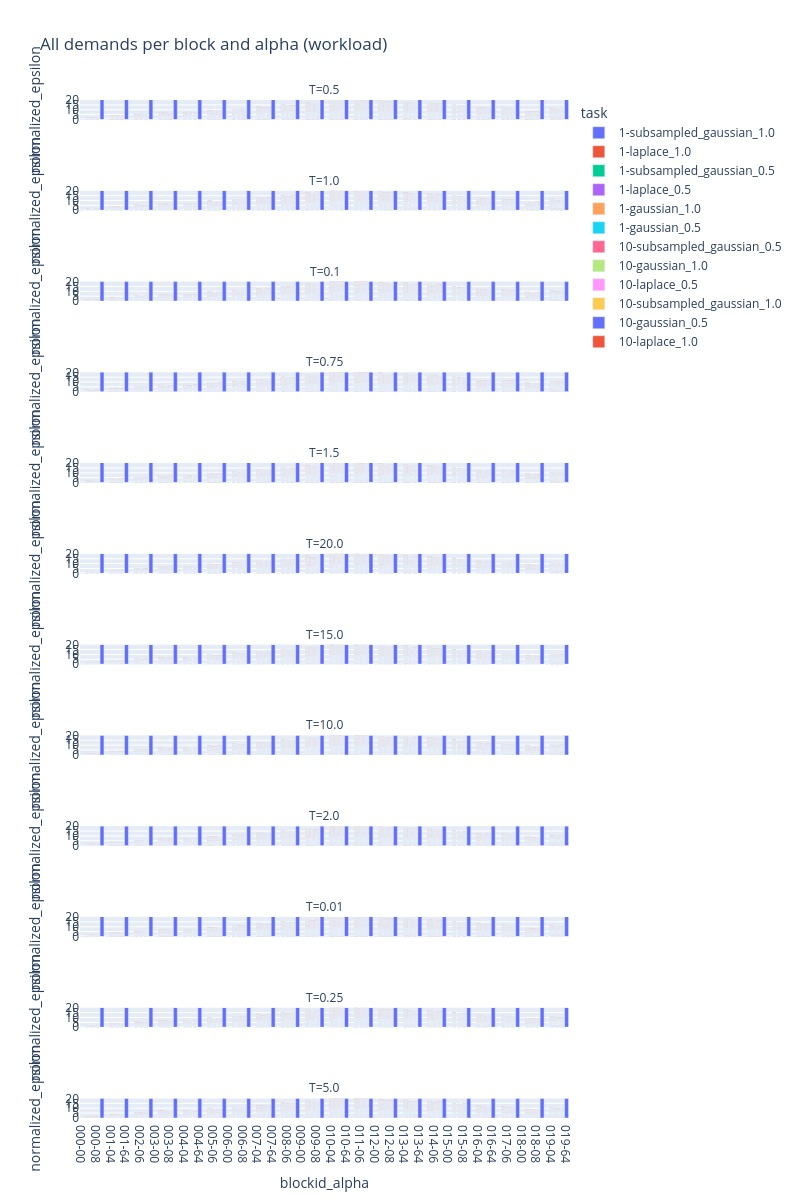

In [24]:
px.bar(
    # df,
    df.query("metric == 'BatchOverflowRelevance'"),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,20],
#     color="log_id",
    color="task",
    # barmode="group",
    # pattern_shape="allocated",
    facet_col="T",
    facet_col_wrap=1,
    height=1200,
    width=800,
    title="All demands per block and alpha (workload)"
#     animation_frame="id"
)
# .write_image("out.png")

Good news (somewhat): the workload is the same. So the reason why FCFS performances change is not a randomness issue. What else?

TODO:
    - plot two allocations for FCFS? We won't probably see anything, I need a way to replay scheduling step by step...
    - Maybe the two distributions are identical but the ids are slightly shuffled. (probably no)
    - Just try a different seed and see if the pattern is identical. (done: the pattern is the same. Also, the curves show a clear trend, not random points)

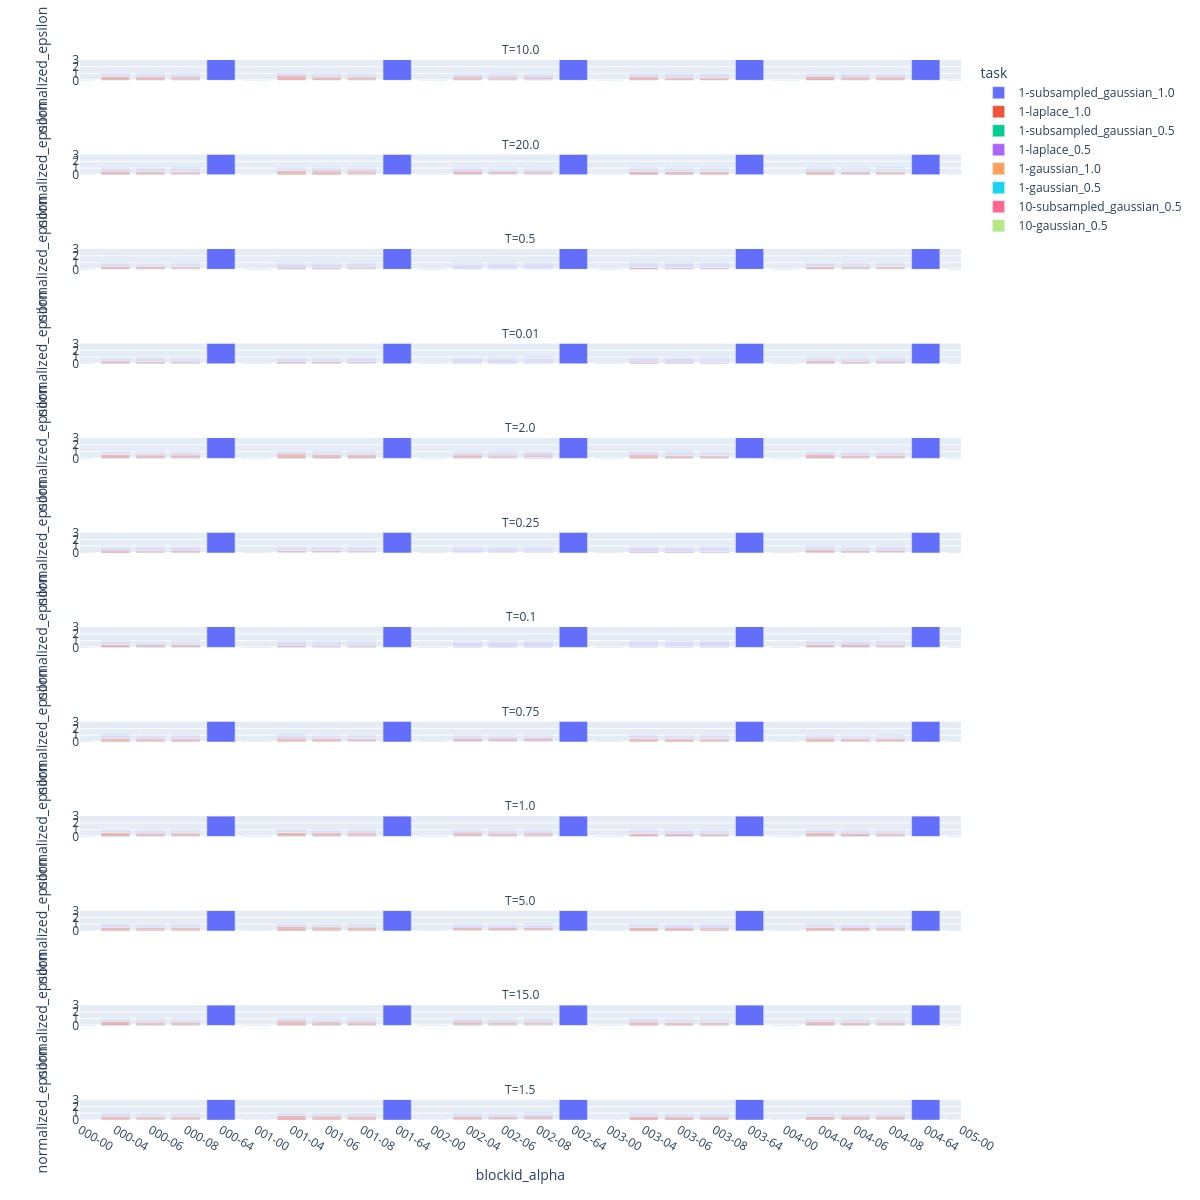

In [25]:
px.bar(
    df.query("allocated and metric == 'Fcfs'"),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
    range_x = [0, 5 * 5],
    color="task",
    facet_col="T",
    facet_col_wrap=1,
    height=1200,
    width=1200,
    # title="Allocated demands for each scheduler",
)

It confirms my explanation about long tasks. We can see that for T=10 and 20 we have some deep blue Laplace curves that are scheduled, with 10 blocks.

How does this effect impact Overflow Relevance? If we always request the latest blocks, I think that it is quite inevitable. If we request random blocks, this effect happens too because we can't request blocks from the future, but when the pool of blocks is large enough the effect should be smaller. Indeed, T = 5 to T = 10 doesn't discriminate much if the long random tasks can request 10 blocks in [0,100] vs [0,105]

TODO:
    - Try to play with intermediary lifetimes. Does this effect exist when we have some form of pacing? Probably.
    - What if we run the simulation for much longer, and take T >> max_number_blocks? This should damp this effect due to the granularity of the demands. However, using very large values for T is pointless.

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


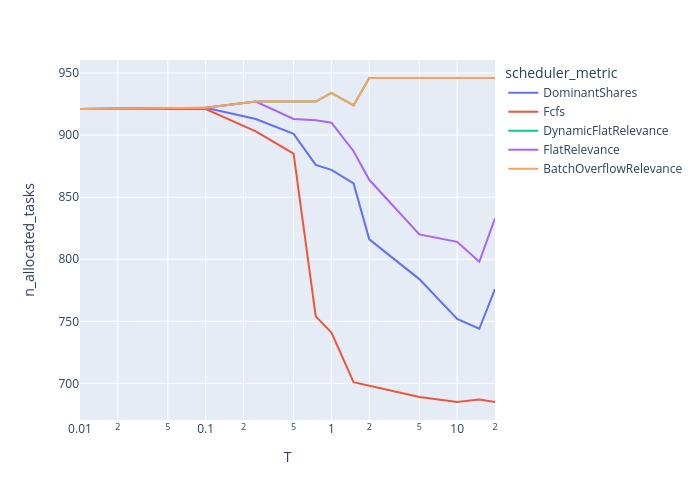

In [26]:
# This is with N = 10k, various T, D = 1
# What I expect to see:the end of the graph should be almost identical, since for T = 10 or 20, unlocking immediately and unlocking over 1 day is almost equivalent (except for the last few blocks)
# For small T: does it simply create a shift in the tasks? You wait a bit, then you schedule. Yes, that's the point: hopefully you got some better tasks (asking the same block) in the meantime.
# Aha: having T > 1 might not be meaningful, because all the other tasks are now requesting the newer block. Not much point waiting, unless you are waiting for 10-block tasks.
# And you will have plenty of 10-block tasks, no? 
df = load_latest_ray_experiment()
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


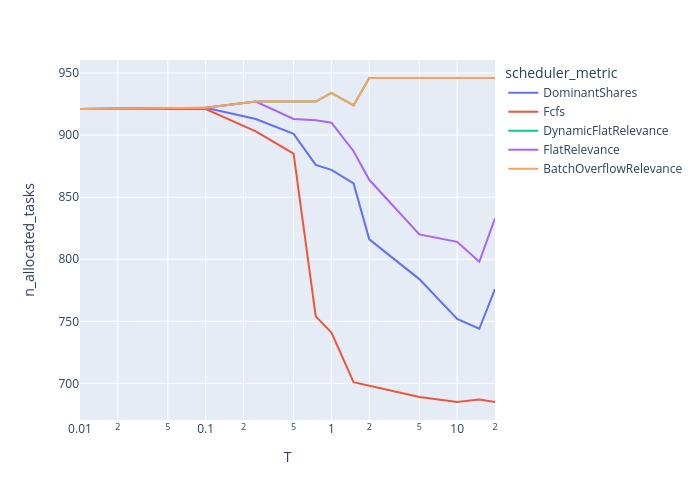

In [27]:
# Same, but with more granularity
df = load_latest_ray_experiment()
px.line(
    df.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
)

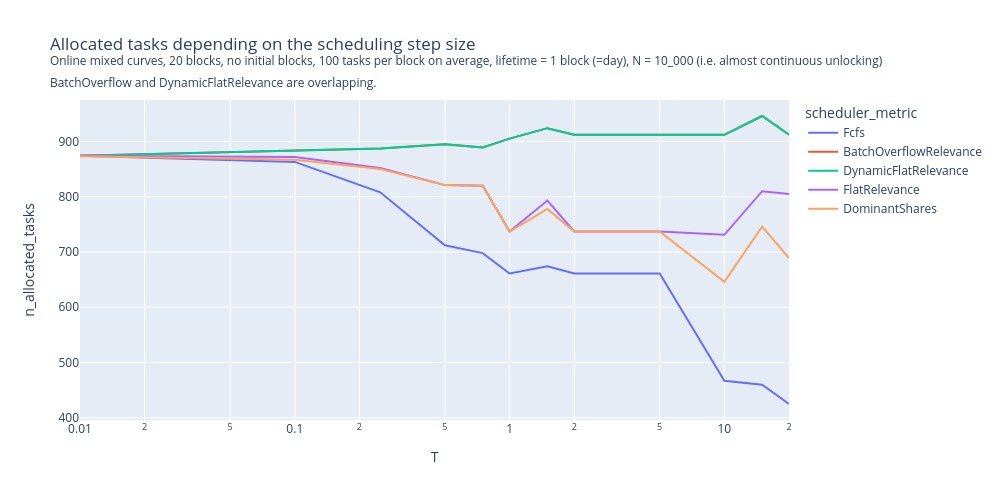

In [28]:
ddf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-21_21-51-56"))
px.line(
    ddf.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
    width=1_000,
    title="Allocated tasks depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 1 block (=day), N = 10_000 (i.e. almost continuous unlocking)<br>BatchOverflow and DynamicFlatRelevance are overlapping. </sup>"
)

Ok, compared to last graph, for same T, increasing the lifetime increases the number of allocated tasks. Because we don't allocate right away, we slowly unlock.

But, why does moving T from 0.25 to 0.75 gives worse performances for FCFS?
- If you are at the beginning of a day, waiting 0.5 day gives about 50 more tasks, requesting the exact same blocks. 
- We shouldn't have the same effect as T=5 vs T=10, should we? Maybe the drop comes from the few cases where scheduling less frequently makes you schedule right after a new block has been released, allowing you to fit some long and inefficient tasks that wouldn't have been able to fit in two settings?


TODO: 
- understand which tasks get scheduled or not when I change T a little bit (with plots)
- maybe I should increase the load? Double check that there are enough tasks for the DPF killer effect. Based on a clean offline baseline (see above todo)
- try to see what happens if I add profit. The implicit budget regulation might be less important

In [29]:
df = load_latest_scheduling_results(alphas=True, expname="exp_1121-215154")
maxeps = {}
for task_file in Path("/home/pierre/privacypacking/data/mixed_curves/tasks").glob("*.yaml"):
    task_dict = yaml.safe_load(task_file.open("r"))
    maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
maxeps

def get_task_name(s):
    n,m = s.split("-")
    return f"{n}-{maxeps[m]}"

df["task"] = df["nblocks_maxeps"].apply(get_task_name)

/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215229_e85d85.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215456_73d136.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215430_5d3b8b.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215509_0f8aac.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215446_f2206d.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215259_65229e.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215527_0b2f4b.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unlocking_DominantShares/1121-215351_9305b3.json
/home/pierre/privacypacking/logs/exp_1121-215154/time_based_budget_unloc

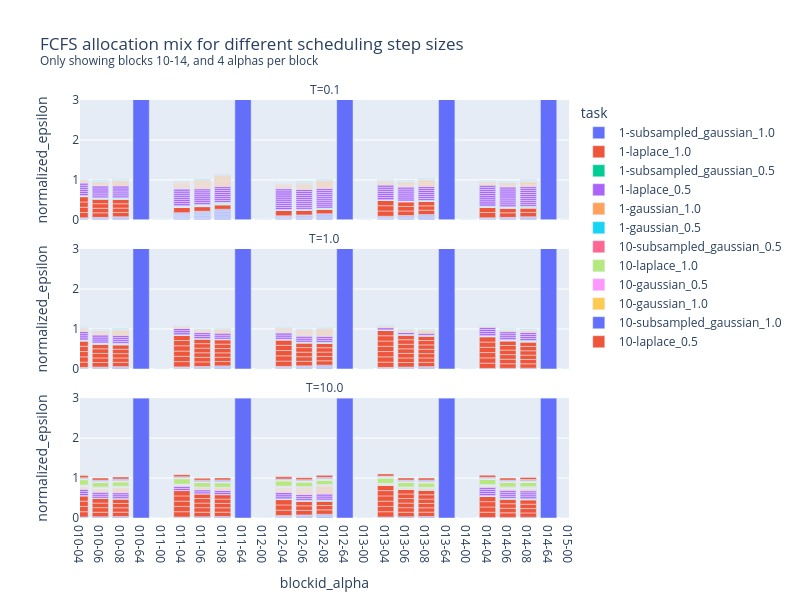

In [30]:
px.bar(
    df.query("allocated and metric == 'Fcfs' and T in [0.1,1,10]").sort_values(["blockid_alpha", "T"]),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
    range_x = [10 * 5 + 1, 15 * 5],
    color="task",
    facet_col="T",
    facet_col_wrap=1,
    height=600,
    width=800,
    title="FCFS allocation mix for different scheduling step sizes<br><sup>Only showing blocks 10-14, and 4 alphas per block</sup>",
)

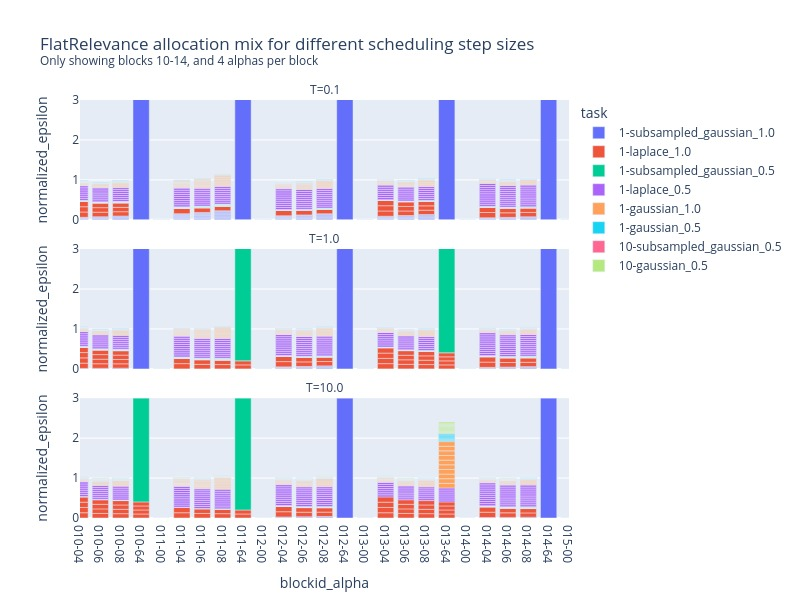

In [31]:
px.bar(
    df.query("allocated and metric == 'FlatRelevance' and T in [0.1,1,10]").sort_values(["blockid_alpha", "T"]),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
    range_x = [10 * 5 + 1, 15 * 5],
    color="task",
    facet_col="T",
    facet_col_wrap=1,
    height=600,
    width=800,
    title="FlatRelevance allocation mix for different scheduling step sizes<br><sup>Only showing blocks 10-14, and 4 alphas per block</sup>",
)

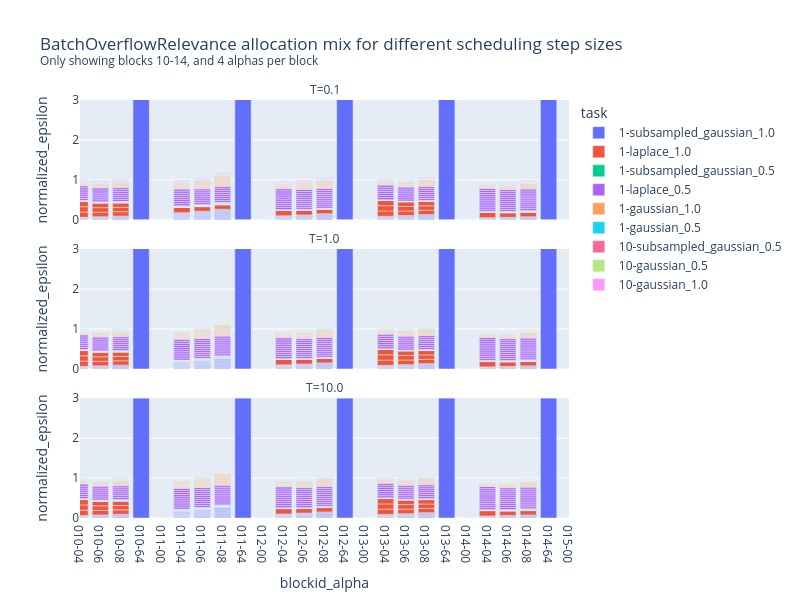

In [32]:
px.bar(
    df.query("allocated and metric == 'BatchOverflowRelevance' and T in [0.1,1,10]").sort_values(["blockid_alpha", "T"]),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
    range_x = [10 * 5 + 1, 15 * 5],
    color="task",
    facet_col="T",
    facet_col_wrap=1,
    height=600,
    width=800,
    title="BatchOverflowRelevance allocation mix for different scheduling step sizes<br><sup>Only showing blocks 10-14, and 4 alphas per block</sup>",
)

/home/pierre/privacypacking/logs/ray/run_and_report_2021-11-22_20-08-29


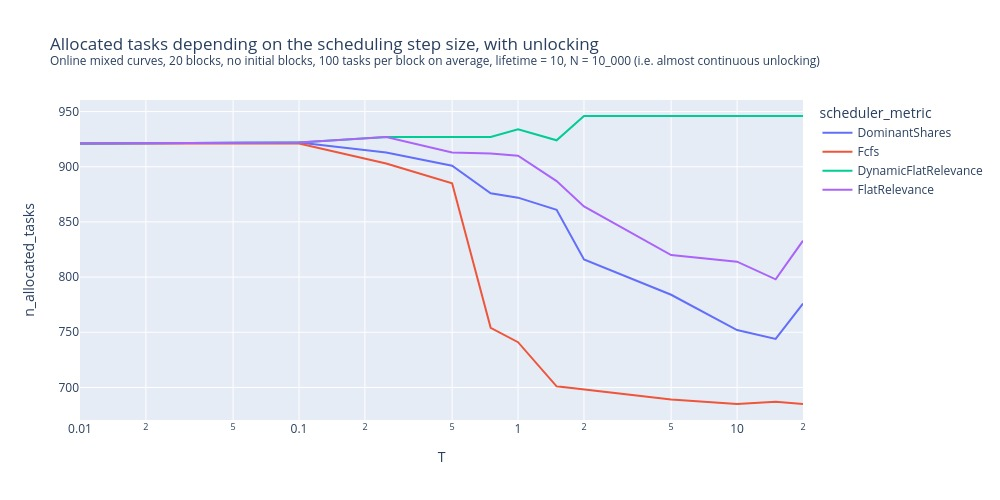

In [33]:
ddf = load_latest_ray_experiment()
px.line(
    ddf.query("scheduler_metric != 'BatchOverflowRelevance'").sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    log_x=True,
    width=1_000,
    title="Allocated tasks depending on the scheduling step size, with unlocking<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 10, N = 10_000 (i.e. almost continuous unlocking)</sup>"
)

In [34]:
df = load_latest_scheduling_results(alphas=True)
maxeps = {}
for task_file in Path("/home/pierre/privacypacking/data/mixed_curves/tasks").glob("*.yaml"):
    task_dict = yaml.safe_load(task_file.open("r"))
    maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
maxeps

def get_task_name(s):
    n,m = s.split("-")
    return f"{n}-{maxeps[m]}"

df["task"] = df["nblocks_maxeps"].apply(get_task_name)

/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201127_01f710.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201112_b98692.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201057_a80059.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201142_7fd610.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-200832_2eec37.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201010_6fe2bb.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201214_c86d8d.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unlocking_DominantShares/1122-201033_b4d164.json
/home/pierre/privacypacking/logs/exp_1122-200827/time_based_budget_unloc

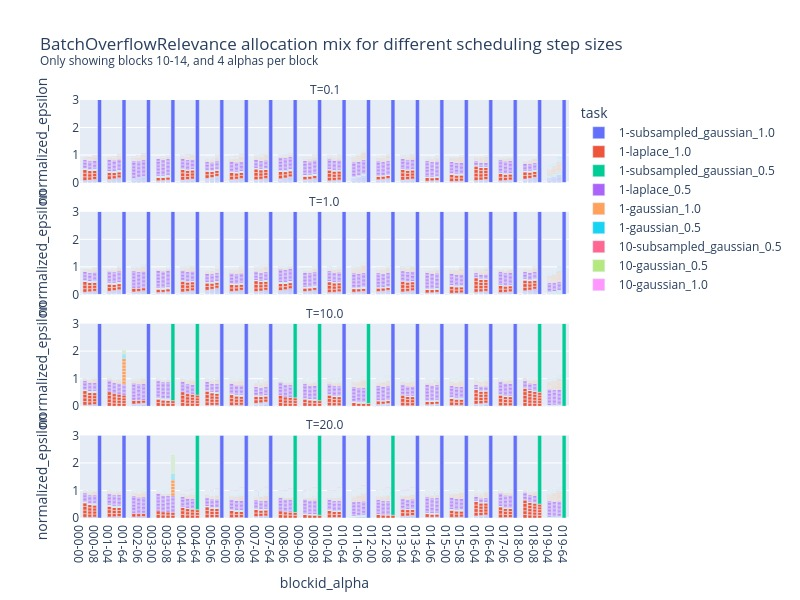

In [35]:
px.bar(
    df.query("allocated and metric == 'FlatRelevance' and T in [0.1,1,10,20]").sort_values(["blockid_alpha", "T"]),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
    range_x = [0, 20 * 5],
    color="task",
    facet_col="T",
    facet_col_wrap=1,
    height=600,
    width=800,
    title="BatchOverflowRelevance allocation mix for different scheduling step sizes<br><sup>Only showing blocks 10-14, and 4 alphas per block</sup>",
)

In [36]:
df.query("allocated").scheduling_delay

66565       5.958754
100650      2.958754
135485      9.958754
169815      0.028754
205440      2.958754
             ...    
1503269    18.011581
1538279     3.011581
1608179     0.011581
1643329     0.511581
1678209     0.511581
Name: scheduling_delay, Length: 295695, dtype: float64